## A Demonstrate of the Bayesian Seasonal Global Trend (BSGT) Model

In [1]:
%load_ext lab_black

In [2]:
import os

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.special import boxcox, inv_boxcox

import jax.numpy as np
from jax import lax, random, vmap
from jax.nn import softmax

import numpyro

numpyro.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

/tmp/Python/python-3.9.9/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/tmp/Python/python-3.9.9/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


Length of time series: 144


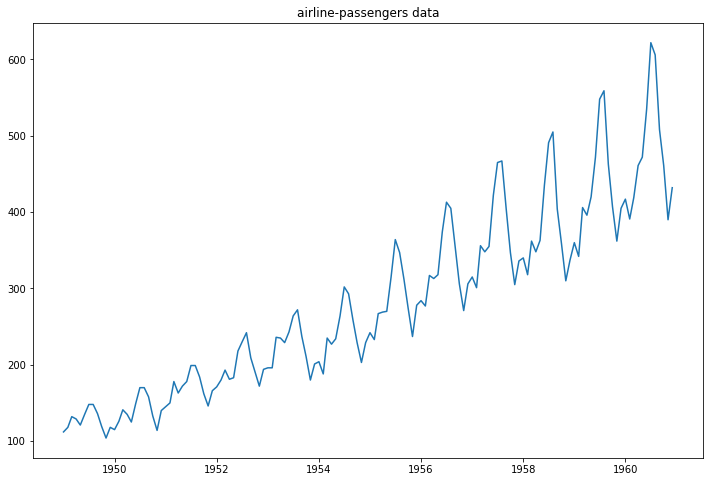

In [3]:
# load example data from the local csv file and plot.
dataset = pd.read_csv(
    "../../data/airline-passengers.csv", header=0, index_col=0, parse_dates=True
)
y_data = dataset.Passengers
data = y_data.values.astype(np.float32)
print("Length of time series:", data.shape[0])
plt.figure(figsize=(12, 8))
plt.plot(y_data)
plt.title("airline-passengers data")
plt.show()

### Prepare the functions to estimate and forecast BSGT model

In [4]:
def scan_exp_val(y, init_s, level_sm, s_sm, coef_trend, pow_trend, pow_season):
    seasonality = init_s.shape[0]

    def scan_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level ** pow_season
        exp_val = level + coef_trend * level ** pow_trend + season
        exp_val = np.clip(exp_val, a_min=0)

        moving_sum = (
            moving_sum + y[t] - np.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = np.where(t >= seasonality, moving_sum / seasonality, y[t] - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = np.clip(level, a_min=0)
        new_s = (s_sm * (y[t] - level) / season + (1 - s_sm)) * s[0]
        s = np.concatenate([s[1:], new_s[None]], axis=0)
        return (level, s, moving_sum), exp_val

    level_init = y[0]
    s_init = np.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    (last_level, last_s, moving_sum), exp_vals = lax.scan(
        scan_fn, (level_init, s_init, moving_sum), np.arange(1, y.shape[0])
    )
    return exp_vals, last_level, last_s

In [5]:
def sgt(y, seasonality):
    # heuristically, standard derivation of Cauchy prior depends on the max value of data
    cauchy_sd = np.max(y) / 150

    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    exp_val, last_level, last_s = scan_exp_val(
        y, init_s, level_sm, s_sm, coef_trend, pow_trend, pow_season
    )
    omega = sigma * exp_val ** powx + offset_sigma
    numpyro.sample("y", dist.StudentT(nu, exp_val, omega), obs=y[1:])
    # we return last `level` and last `s` for forecasting
    return last_level, last_s

In [6]:
def sgt_forecast(future, sample, y, level, s):
    seasonality = s.shape[0]
    moving_sum = np.sum(y[-seasonality:])
    pow_trend = 1.5 * sample["pow_trend_beta"] - 0.5
    yfs = [0] * (seasonality + future)
    for t in range(future):
        season = s[0] * level ** sample["pow_season"]
        exp_val = level + sample["coef_trend"] * level ** pow_trend + season
        exp_val = np.clip(exp_val, a_min=0)
        omega = sample["sigma"] * exp_val ** sample["powx"] + sample["offset_sigma"]
        yf = numpyro.sample(
            "yf[{}]".format(t), dist.StudentT(sample["nu"], exp_val, omega)
        )
        yf = np.clip(yf, a_min=1e-30)
        yfs[t] = yf

        moving_sum = (
            moving_sum
            + yf
            - np.where(t >= seasonality, yfs[t - seasonality], y[-seasonality + t])
        )
        level_p = moving_sum / seasonality
        level_tmp = sample["level_sm"] * level_p + (1 - sample["level_sm"]) * level
        level = np.where(level_tmp > 1e-30, level_tmp, level)
        # s is repeated instead of being updated
        s = np.concatenate([s[1:], s[:1]], axis=0)


def forecast(future, rng_key, sample, y, seasonality):
    level, s = handlers.substitute(sgt, sample)(y, seasonality)
    forecast_model = handlers.seed(sgt_forecast, rng_key)
    forecast_trace = handlers.trace(forecast_model).get_trace(
        future, sample, y, level, s
    )
    results = [
        np.clip(forecast_trace["yf[{}]".format(t)]["value"], a_min=1e-30)
        for t in range(future)
    ]
    return np.stack(results, axis=0)

### This is the forecast based on the Box-Cox transformation

In [7]:
y_raw = y_data.values.astype(np.float32)
split = int(len(y_raw) * 0.90)
_, bc_lambda = sp.stats.boxcox(y_raw[:split])
y_bc_raw = boxcox(y_raw, bc_lambda)
y_train, y_test = np.array(y_bc_raw[:split]), y_raw[split:]
seasonality = 12

/tmp/Python/python-3.9.9/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [8]:
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=4)
mcmc.run(random.PRNGKey(2020), y_train, seasonality=seasonality)
# mcmc.print_summary()
samples = mcmc.get_samples()

rng_keys = random.split(random.PRNGKey(2020), samples["nu"].shape[0])
forecast_marginal = vmap(
    lambda rng_key, sample: forecast(
        len(y_test), rng_key, sample, y_train, seasonality=seasonality
    )
)(rng_keys, samples)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [9]:
y_pred = inv_boxcox(np.median(forecast_marginal, axis=0), bc_lambda)
sMAPE = np.mean(np.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = np.sqrt(np.mean((y_pred - y_test) ** 2))

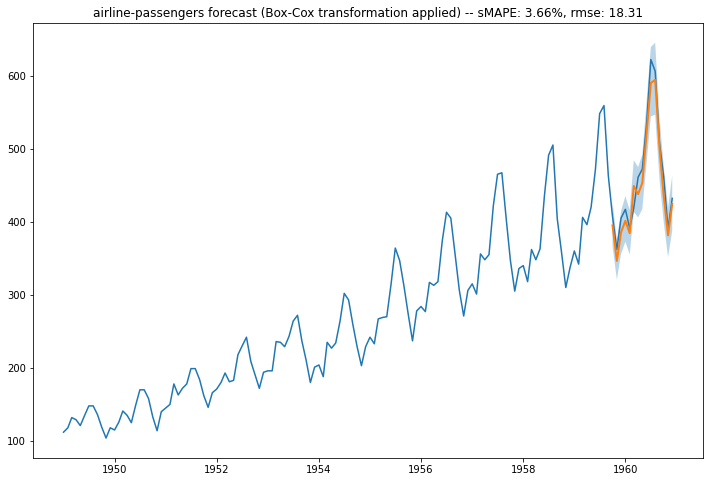

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(y_data.index, y_raw)
t_future = y_data.index[split:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(
    t_future, inv_boxcox(hpd_low, bc_lambda), inv_boxcox(hpd_high, bc_lambda), alpha=0.3
)
plt.title(
    "airline-passengers forecast (Box-Cox transformation applied) -- sMAPE: {:.2f}%, rmse: {:.2f}".format(
        sMAPE, msqrt
    )
)
plt.show()

### This is the forecast based on the log transformation

In [11]:
y = np.log(data)
split = int(len(y) * 0.90)
y_train, y_test = np.array(y[:split]), y[split:]
seasonality = 12

In [12]:
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=4)
mcmc.run(random.PRNGKey(2020), y_train, seasonality=seasonality)
# mcmc.print_summary()
samples = mcmc.get_samples()

rng_keys = random.split(random.PRNGKey(2020), samples["nu"].shape[0])
forecast_marginal = vmap(
    lambda rng_key, sample: forecast(
        len(y_test), rng_key, sample, y_train, seasonality=seasonality
    )
)(rng_keys, samples)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [13]:
y_pred = np.median(forecast_marginal, axis=0)
sMAPE = (
    np.mean(np.abs(np.exp(y_pred) - np.exp(y_test)) / (np.exp(y_pred) + np.exp(y_test)))
    * 200
)
msqrt = np.sqrt(np.mean((np.exp(y_pred) - np.exp(y_test)) ** 2))

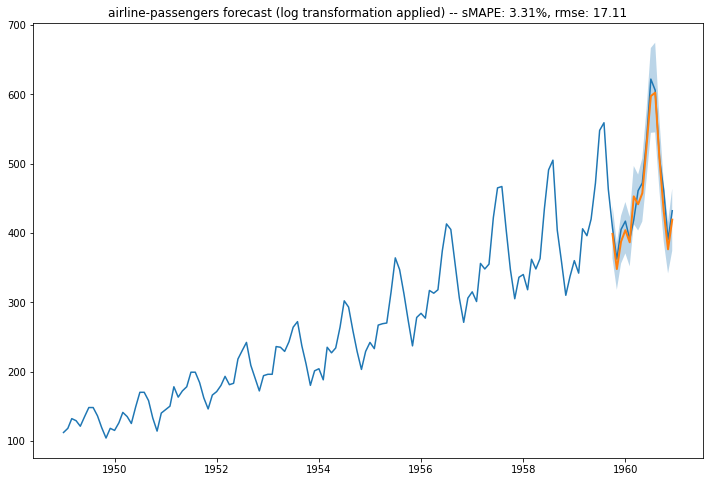

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(y_data.index, np.exp(y))
t_future = y_data.index[split:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, np.exp(y_pred), lw=2)
plt.fill_between(t_future, np.exp(hpd_low), np.exp(hpd_high), alpha=0.3)
plt.title(
    "airline-passengers forecast (log transformation applied) -- sMAPE: {:.2f}%, rmse: {:.2f}".format(
        sMAPE, msqrt
    )
)
plt.show()

### This is the forecast without any transformation on the raw data.

In [15]:
split = int(len(data) * 0.90)
y_train, y_test = np.array(data[:split]), data[split:]
seasonality = 12

In [16]:
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=500, num_samples=2000, num_chains=4)
mcmc.run(random.PRNGKey(2020), y_train, seasonality=seasonality)
# mcmc.print_summary()
samples = mcmc.get_samples()

rng_keys = random.split(random.PRNGKey(2020), samples["nu"].shape[0])
forecast_marginal = vmap(
    lambda rng_key, sample: forecast(
        len(y_test), rng_key, sample, y_train, seasonality=seasonality
    )
)(rng_keys, samples)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [17]:
y_pred = np.median(forecast_marginal, axis=0)
sMAPE = np.mean(np.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = np.sqrt(np.mean((y_pred - y_test) ** 2))

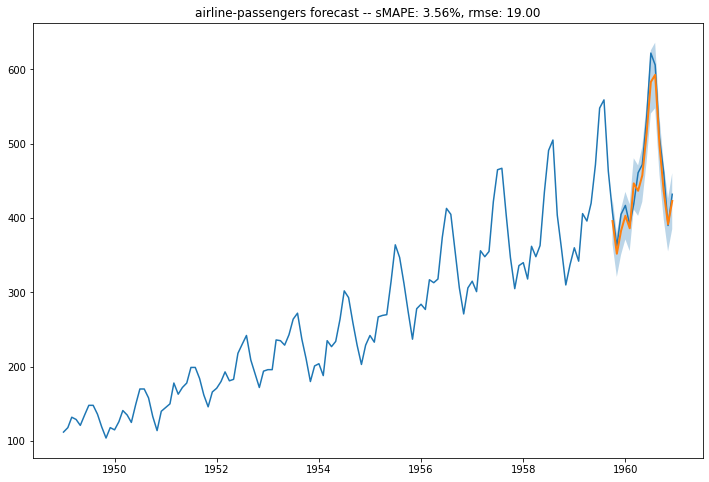

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(y_data.index, data)
t_future = y_data.index[split:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title(
    "airline-passengers forecast -- sMAPE: {:.2f}%, rmse: {:.2f}".format(sMAPE, msqrt)
)
plt.show()